In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import geopandas as gpd
import pycountry
from ydata_profiling import ProfileReport
from scipy.stats import chi2_contingency

%matplotlib inline
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
pd.set_option('display.max_rows', None)

c:\Users\Ale\anaconda3\envs\alt-protein\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read File, EDA, Data Cleaning & Transforming

In [2]:
df = pd.read_csv('proteins.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('/', '_')
df.head()

# df.to_csv('proteins_clean.csv')

,company,brief_description,protein_category,company_focus,company_type,technology_focus,product_type,animal_type_analog,ingredient_type,operating_regions,country_region,state,city,website,year_founded,founders,logo
0,FrieslandCampina,Dutch multinational dairy cooperative that has...,Plant-based,Dairy,Diversified,End product formulation and manufacturing,Milk,NaN,"Oat,Soy",Europe,Netherlands,NaN,Amersfoort,https://www.frieslandcampina.com/,2008.0,NaN,logo-fc-full.svg (https://v5.airtableuserconte...
1,Finless Foods,U.S.-based company working on plant-based fish...,"Cultivated,Plant-based","Meat,Seafood",Specialized (focused on alternative proteins),"Cell culture media,End product formulation and...",Whole muscle meat/seafood,Fish,NaN,U.S. and Canada,United States,California,San Francisco,https://finlessfoods.com/,2017.0,"Mike Selden, Brian Wyrwas",Capture.JPG (https://v5.airtableusercontent.co...
2,Avant Meats,Hong Kong-based company using proprietary biot...,Cultivated,"Meat,Seafood",Specialized (focused on alternative proteins),End product formulation and manufacturing,Ground meat/seafood,Fish,NaN,Asia Pacific,Mainland China,NaN,Hong Kong SAR,https://www.avantmeats.com/,2018.0,"Carrie Chan, Mario Chin",tbnkq9whzxvh5fxpj6uj.png (https://v5.airtableu...
3,Upside Foods,U.S.-based cultivated meat startup producing b...,Cultivated,Meat,Specialized (focused on alternative proteins),"Cell line development,End product formulation ...",NaN,"Duck,Beef/veal,Chicken",NaN,U.S. and Canada,United States,California,San Leandro,http://www.memphismeats.com/,2015.0,"Uma Valeti, Nicholas Genovese, Will Clem",Horizontal_Black.png (https://v5.airtableuserc...
4,BioTech Foods,Spain-based startup producing cultivated meat ...,Cultivated,Meat,Specialized (focused on alternative proteins),End product formulation and manufacturing,Ground meat/seafood,Beef/veal,NaN,Europe,Spain,NaN,San Sebastián,https://biotech-foods.com/,2017.0,Mercedes Vila Juarez,dko8ln1xykb67qgiek0w.png (https://v5.airtableu...


## Automated EDA (see `alt_proteins_EDA.html`)

![EDA](assets/EDA.gif)

In [3]:
# # EDA Profiling
# profile = ProfileReport(df, title='Alt Proteins EDA')
# profile.to_file("alt_proteins_EDA.html")

In [4]:
columns_to_sort = ['protein_category', 'company_focus', 
                   'technology_focus','product_type', 'animal_type_analog', 
                   'ingredient_type','operating_regions', 
                   'country_region', 'state', 'city', 'year_founded']

unique_values = {}

for column in columns_to_sort:
    unique_values[column] = np.sort(df[column].astype(str).unique())

# for column, values in unique_values.items():
#     print(f'{column}:', values)

- Unnest multiple values

In [5]:
nested_columns = ['protein_category', 'company_focus', 'technology_focus',
 'product_type', 'animal_type_analog', 'ingredient_type','operating_regions', 
 ]

df_explode = df.copy()

# Converting multi-valued cells into lists and exploding the columns
for column in nested_columns:
    df_explode[column] = df_explode[column].str.split(',')
    df_explode = df_explode.explode(column)

df_explode.reset_index(inplace=True)
df_explode.rename(columns={'index': 'original_index'}, inplace=True)

df_explode.head()

# df_explode.to_csv('proteins_unpacked.csv', index=False)


,original_index,company,brief_description,protein_category,company_focus,company_type,technology_focus,product_type,animal_type_analog,ingredient_type,operating_regions,country_region,state,city,website,year_founded,founders,logo
0,0,FrieslandCampina,Dutch multinational dairy cooperative that has...,Plant-based,Dairy,Diversified,End product formulation and manufacturing,Milk,NaN,Oat,Europe,Netherlands,NaN,Amersfoort,https://www.frieslandcampina.com/,2008.0,NaN,logo-fc-full.svg (https://v5.airtableuserconte...
1,0,FrieslandCampina,Dutch multinational dairy cooperative that has...,Plant-based,Dairy,Diversified,End product formulation and manufacturing,Milk,NaN,Soy,Europe,Netherlands,NaN,Amersfoort,https://www.frieslandcampina.com/,2008.0,NaN,logo-fc-full.svg (https://v5.airtableuserconte...
2,1,Finless Foods,U.S.-based company working on plant-based fish...,Cultivated,Meat,Specialized (focused on alternative proteins),Cell culture media,Whole muscle meat/seafood,Fish,NaN,U.S. and Canada,United States,California,San Francisco,https://finlessfoods.com/,2017.0,"Mike Selden, Brian Wyrwas",Capture.JPG (https://v5.airtableusercontent.co...
3,1,Finless Foods,U.S.-based company working on plant-based fish...,Cultivated,Meat,Specialized (focused on alternative proteins),End product formulation and manufacturing,Whole muscle meat/seafood,Fish,NaN,U.S. and Canada,United States,California,San Francisco,https://finlessfoods.com/,2017.0,"Mike Selden, Brian Wyrwas",Capture.JPG (https://v5.airtableusercontent.co...
4,1,Finless Foods,U.S.-based company working on plant-based fish...,Cultivated,Seafood,Specialized (focused on alternative proteins),Cell culture media,Whole muscle meat/seafood,Fish,NaN,U.S. and Canada,United States,California,San Francisco,https://finlessfoods.com/,2017.0,"Mike Selden, Brian Wyrwas",Capture.JPG (https://v5.airtableusercontent.co...


In [6]:
# # EDA Profiling
# profile = ProfileReport(df, title='Alt Proteins EDA - Unpacked')
# profile.to_file("alt_proteins_EDA_unpack.html")

In [7]:
fig = px.histogram(df, x=df['year_founded'], nbins=100, 
                   title='Creation of alt protein companies spiked after 2010',
                   color_discrete_sequence=['gray'])
fig.update_traces(marker=dict(line=dict(width=1, color='black'))) # show border of bins
fig.update_yaxes(title='Number of Companies')
fig.update_xaxes(title='')
fig.show()

In [8]:
fig = px.histogram(df, x=df[df['year_founded'] > 1970]['year_founded'], nbins=25,
                   color_discrete_sequence=['gray'])
fig.update_traces(marker=dict(line=dict(width=1, color='black'))) # show border of bins
fig.update_yaxes(title='Number of Companies')
fig.update_xaxes(title='',)

# Vertical line
fig.add_shape(
    go.layout.Shape(
        type="line",
        x0=2009.5,
        x1=2009.5,
        y0=0,
        y1=600,  # Adjust height of the histogram
        line=dict(color="red", width=2)
    )
)

fig.update_layout(
    title='Creation of alt protein companies spiked after 2010',
    title_font=dict(size=30)
)

fig.show()

- There appears to be companies founded before 1900. These dates are not verified so they are considered outliers.

In [9]:
comp_1800 = df[df['year_founded'] <= 1800][['year_founded', 'company', 'brief_description']]
comp_1800 = comp_1800.sort_values(by='year_founded')
comp_1800.columns = ['Year Founded', 'Company Name', 'What does it do?']

fig = go.Figure(data=[go.Table(
    columnwidth=[200, 200, 800],
    header=dict(values=list(comp_1800.columns)),
    cells=dict(values=[comp_1800[col] for col in comp_1800.columns],
               align=['center', 'center', 'left'])
)])

fig.update_layout(
    margin=dict(l=0, r=0, t=30, b=0),
    width=1000,
    height=300
)

fig.show()

In [10]:
df['year_founded'].describe()

count    1465.000000
mean     2007.939932
std        26.797315
min      1668.000000
25%      2010.000000
50%      2017.000000
75%      2020.000000
max      2023.000000
Name: year_founded, dtype: float64

In [11]:
# Calculating the number of companies founded for each year
companies_per_year = df['year_founded'].value_counts().sort_index()

# Calculating the year-over-year change in the number of companies founded
yearly_change = companies_per_year.diff()

yearly_change = yearly_change.reset_index()

# Create graph
fig = px.line(yearly_change, x=yearly_change[yearly_change['year_founded'] > 1970]['year_founded'],
              y=yearly_change[yearly_change['year_founded'] > 1970]['count'], 
              labels={'count': 'Year-over-year change'},
              color_discrete_sequence=['gray'])

fig.add_scatter(x=[2019], y=yearly_change[yearly_change['year_founded'] == 2019]['count'],
                marker=dict(color='red', size=12),
                showlegend=False)

fig.update_xaxes(title='', tickvals=list(range(1970, 2025, 5)))
fig.update_yaxes(title='Year-Over-Year Change')

fig.update_layout(
    title='Investment in the alt protein starts to fade after 2019',
    title_font=dict(size=30)
)

fig.show()

c:\Users\Ale\anaconda3\envs\alt-protein\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Ale\anaconda3\envs\alt-protein\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



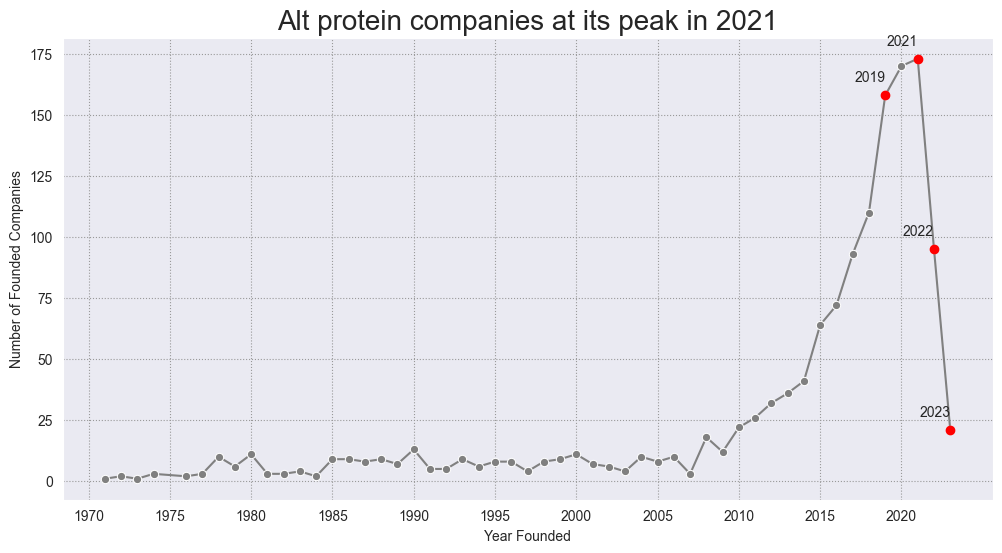

In [12]:
# Count the number of companies founded each year
yearly_company_counts = df['year_founded'].value_counts().sort_index()

# Filter for years greater than 1970
yearly_company_counts = yearly_company_counts[yearly_company_counts.index > 1970]

yearly_company_counts_df = yearly_company_counts.reset_index()
yearly_company_counts_df.columns = ['Year Founded', 'Number of Companies']
yearly_company_counts_df['Year Founded'] = yearly_company_counts_df['Year Founded'].astype(int)

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_company_counts_df, x='Year Founded', y='Number of Companies', marker='o', color='gray')

# Annotate and highlight specific years
highlight_years = [2019, 2021, 2022, 2023]
for year in highlight_years:
    # Annotate
    count = yearly_company_counts_df[yearly_company_counts_df['Year Founded'] == year]['Number of Companies'].values[0]
    plt.annotate(f'{year}', (year, count), textcoords="offset points", xytext=(0,10), ha='right')
    
    # Highlight in red
    plt.scatter(year, count, c="red", edgecolors="red", zorder=2)

plt.title('Alt protein companies at its peak in 2021', fontsize=20)
plt.xlabel('Year Founded')
plt.ylabel('Number of Founded Companies')
plt.grid(True)

# Set x-axis ticks every 5 years
plt.xticks(range(1970, yearly_company_counts_df['Year Founded'].max() + 1, 5))

plt.show()

## Protein Categories

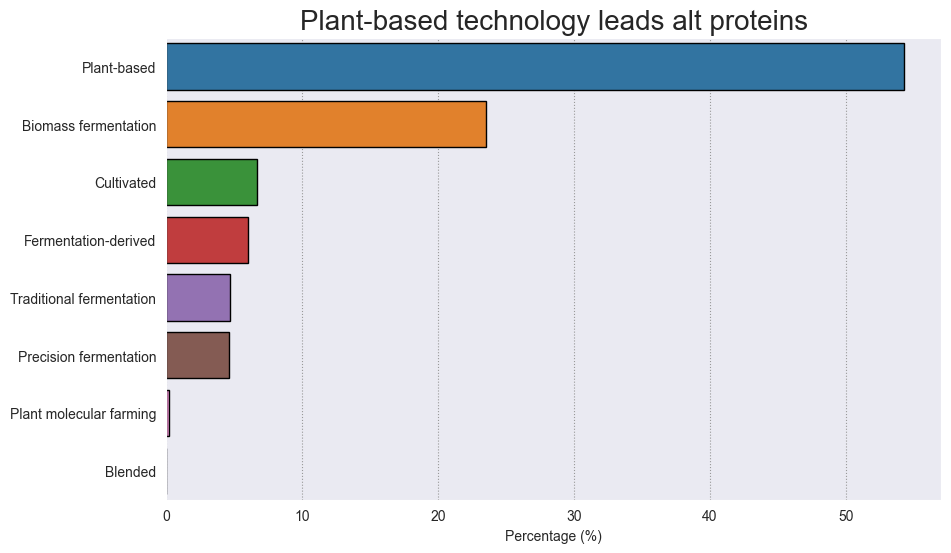

In [13]:
# Calculating the percentage for each category
category_percentages = df_explode['protein_category'].value_counts(normalize=True) * 100
category_percentages = category_percentages.reset_index()
category_percentages.columns = ['protein_category', 'percentage']

# Sorting the categories in descending order of percentage
category_percentages = category_percentages.sort_values(by='percentage', ascending=False)

# Create plot
plt.figure(figsize=(10, 6))
sns.barplot(data=category_percentages, x='percentage', y='protein_category', edgecolor='black')
plt.title('Plant-based technology leads alt proteins', fontsize=20)
plt.ylabel('')
plt.xlabel('Percentage (%)')
plt.show()

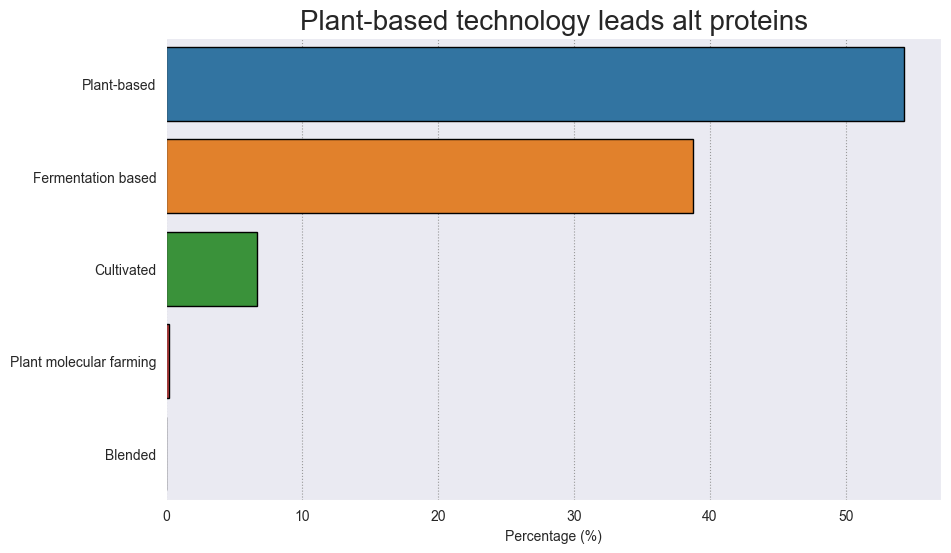

In [14]:
# Create a column with grouped fermentation protein categories
df_explode['protein_category_new'] = df_explode['protein_category'].apply(
    lambda x: "Fermentation based" if "fermentation" in str(x).lower() else x
)
    
# Calculating the percentage for each category
category_percentages = df_explode['protein_category_new'].value_counts(normalize=True) * 100
category_percentages = category_percentages.reset_index()
category_percentages.columns = ['protein_category', 'percentage']

# Sorting the categories in descending order of percentage
category_percentages = category_percentages.sort_values(by='percentage', ascending=False)

# Create plot
plt.figure(figsize=(10, 6))
sns.barplot(data=category_percentages, x='percentage', y='protein_category', edgecolor='black')
plt.title('Plant-based technology leads alt proteins', fontsize=20)
plt.ylabel('')
plt.xlabel('Percentage (%)')
plt.show()

## Industry Focus

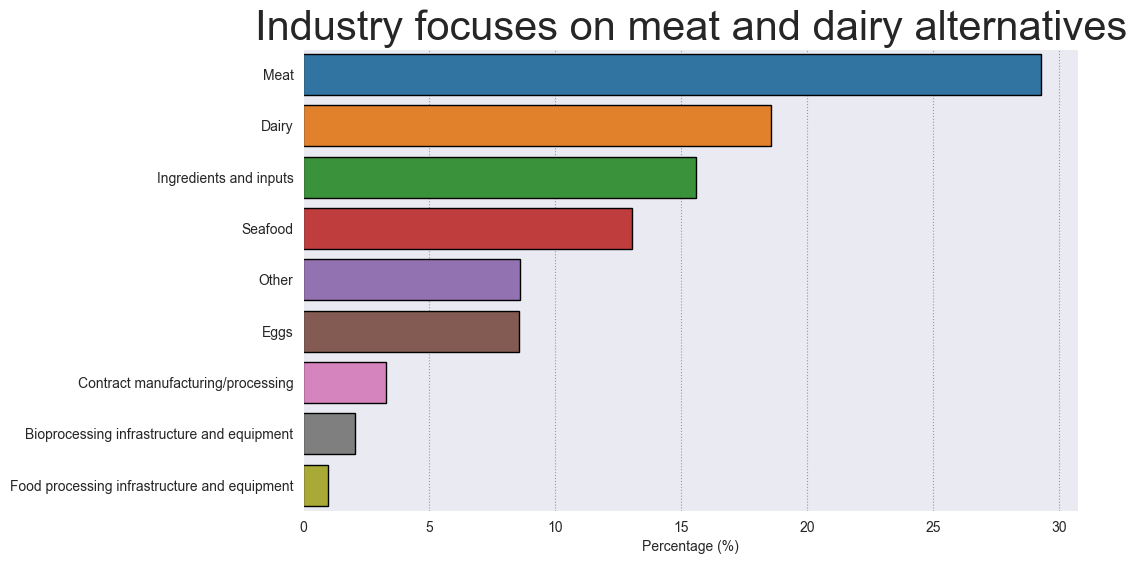

In [15]:
# Calculating the percentage for each category
industry = df_explode['company_focus'].value_counts(normalize=True) * 100
industry = industry.reset_index()
industry.columns = ['company_focus', 'percentage']

# Sorting the categories in descending order of percentage
industry = industry.sort_values(by='percentage', ascending=False)

# Creating the density plot with sorted categories
plt.figure(figsize=(10, 6))
sns.barplot(data=industry, x='percentage', y='company_focus', edgecolor='black')
plt.title('Industry focuses on meat and dairy alternatives', fontsize=30)
plt.ylabel('')
plt.xlabel('Percentage (%)')
plt.show()

C:\Users\Ale\AppData\Local\Temp\ipykernel_7964\3889743313.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\Ale\anaconda3\envs\alt-protein\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Ale\anaconda3\envs\alt-protein\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



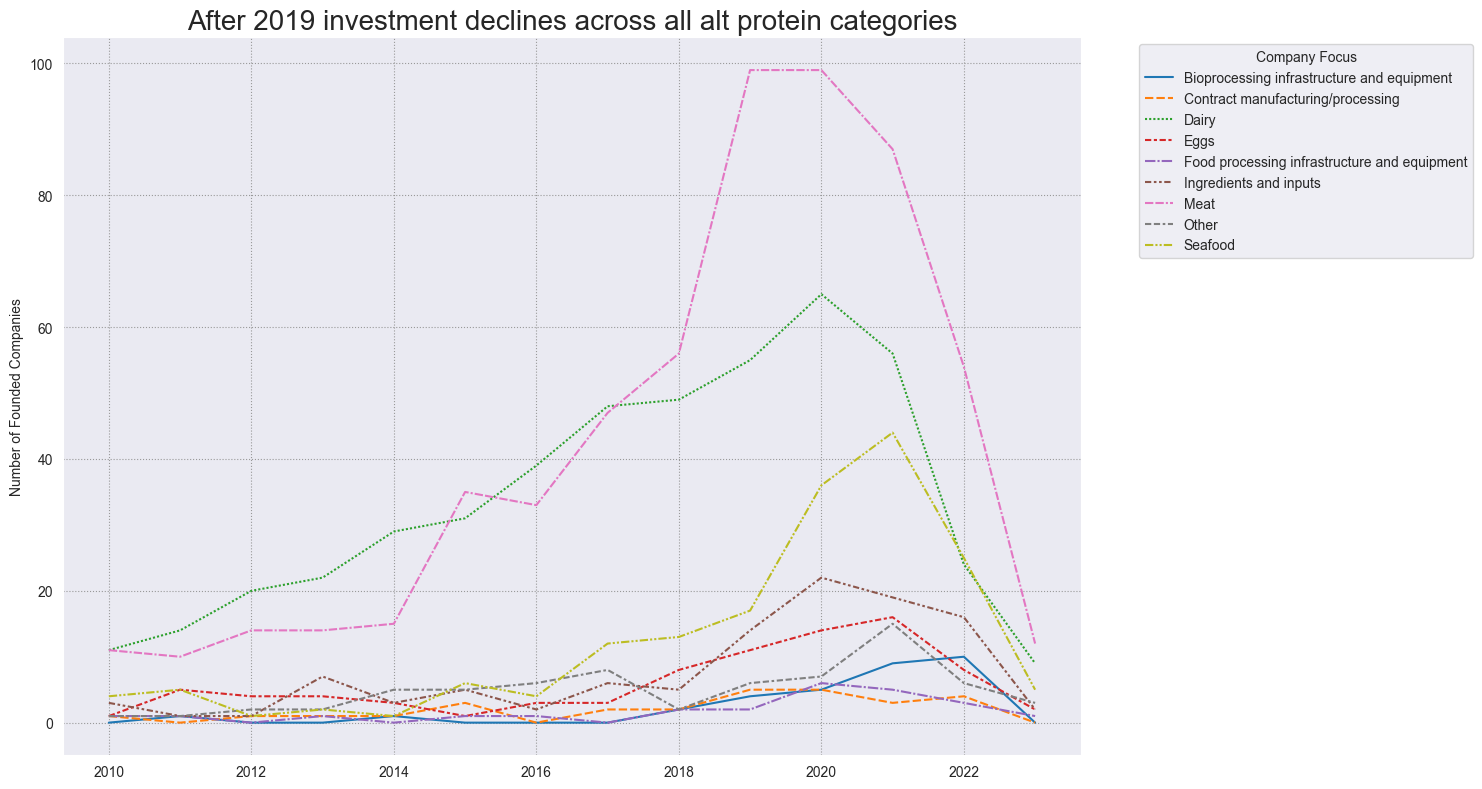

In [16]:
filtered_data = df_explode.dropna(subset=['year_founded', 'company_focus'])
filtered_data['year_founded'] = filtered_data['year_founded'].astype(int)

filtered_data_2010_onwards = filtered_data[filtered_data['year_founded'] >= 2010]
growth_data_2010_onwards = filtered_data_2010_onwards.groupby(['year_founded', 'company_focus']).agg({'company': 'nunique'}).reset_index()

# Pivot the data for plotting
pivot_data_2010_onwards = growth_data_2010_onwards.pivot(index='year_founded', columns='company_focus', values='company').fillna(0)

# Create plot
plt.figure(figsize=(15, 8))
sns.lineplot(data=pivot_data_2010_onwards)
plt.title('After 2019 investment declines across all alt protein categories', fontsize=20)
plt.ylabel('Number of Founded Companies')
plt.xlabel('')
plt.legend(title='Company Focus', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Operating Regions

- Most alt protein companies originate in the USA.
- Most companies have operations in the Asia Pacific region.

<Figure size 1000x600 with 0 Axes>

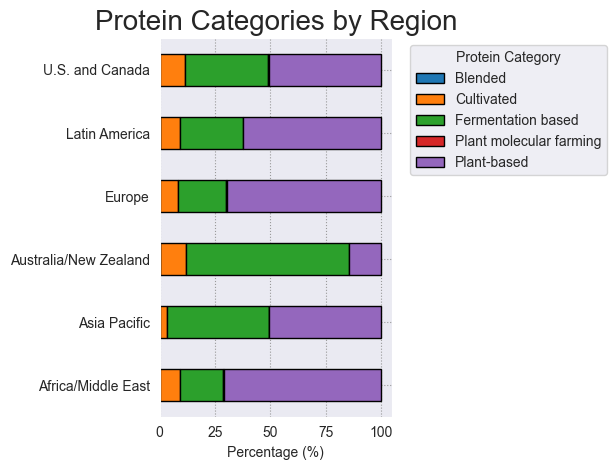

In [17]:
# Select operating_regions excetp for 'Global'
df_explode = df_explode[df_explode['operating_regions'] != 'Global']

pivot_data = df_explode.pivot_table(index='operating_regions', columns='protein_category_new', aggfunc='size', fill_value=0)

# Calculate percentage
pivot_data_percentage = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

# Create plot
plt.figure(figsize=(10, 6))
pivot_data_percentage.plot(kind='barh', stacked=True, edgecolor='black')
plt.title('Protein Categories by Region', fontsize=20)
plt.xlabel('Percentage (%)')
plt.ylabel('')
plt.legend(title='Protein Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

In [18]:
df_explode['operating_regions'].value_counts(normalize=True)

# Preparing data for the Sankey diagram
sankey_data = df_explode.groupby(['operating_regions', 'protein_category_new']).size().reset_index(name='counts')

# Calculate the total counts for each region
total_counts_per_region = sankey_data.groupby('operating_regions')['counts'].transform('sum')

# Calculate the percentage within each group
sankey_data['percentage'] = (sankey_data['counts'] / total_counts_per_region) * 100

# Sort the sankey_data by counts in descending order
sankey_data = sankey_data.sort_values(by='percentage', ascending=False)

# Creating ordered lists of all unique regions and protein categories based on sorted data
all_regions = sankey_data['operating_regions'].unique().tolist()
all_categories = sankey_data['protein_category_new'].unique().tolist()
all_nodes = all_regions + all_categories

# Mapping each unique region and protein category to an index
node_indices = {node: idx for idx, node in enumerate(all_nodes)}

# Preparing the source, target, and value lists for the Sankey diagram
source = sankey_data['operating_regions'].map(node_indices)
target = sankey_data['protein_category_new'].map(node_indices)
value = sankey_data['counts']

# Creating the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_nodes,
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    ))])

fig.update_layout(title_text="Sankey Diagram of Protein Categories per Region", font_size=10)

# Show the figure
fig.show()


## Top 10 Countries Investing in Alt Proteins

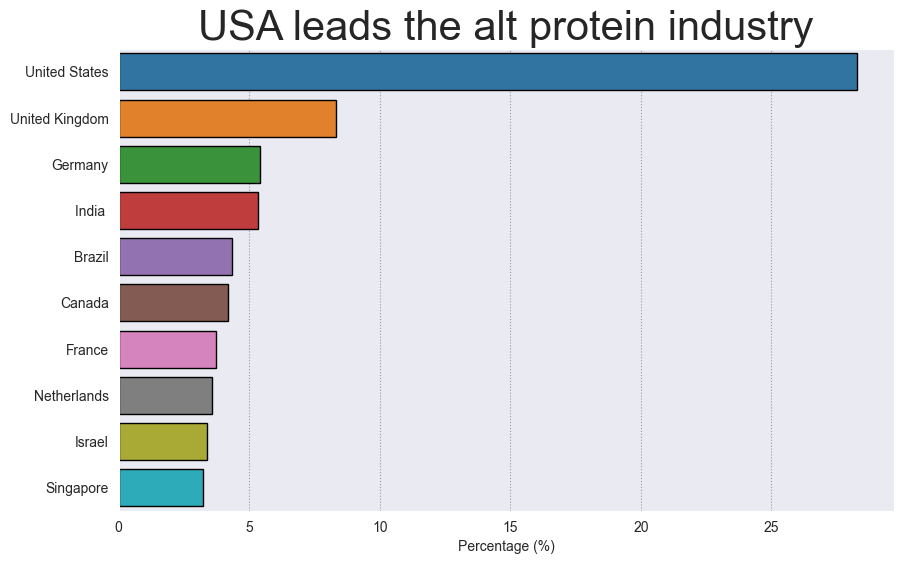

In [19]:
top_countries = df['country_region'].value_counts(normalize=True).reset_index()
top_countries['proportion'] = top_countries['proportion'] * 100

# Creating the density plot with sorted categories
plt.figure(figsize=(10, 6))
sns.barplot(data=top_countries.head(10), x='proportion', y='country_region', edgecolor='black')
plt.title('USA leads the alt protein industry', fontsize=30)
plt.ylabel('')
plt.xlabel('Percentage (%)')
plt.show()

In [20]:
# Function to convert state names to their alpha-2 codes
def state_to_code(state_name):
    try:
        return pycountry.subdivisions.lookup(state_name).code.split('-')[-1]
    except:
        return None
    
us_data = df[df['country_region'] == 'United States']

# Apply the function to standardize state names
us_data['state_code'] = us_data['state'].apply(state_to_code)


state_counts = us_data.groupby('state_code').size().reset_index(name='count')

# Create plot
fig = px.choropleth(state_counts,
                    locations='state_code', 
                    locationmode='USA-states', 
                    color='count',
                    scope="usa",
                    color_continuous_scale="Viridis",
                    title='With the vast majority of companies founded in California'
)

fig.show()


C:\Users\Ale\AppData\Local\Temp\ipykernel_7964\3304577605.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## ML - KModes Clustering

### Market segments (Cluster Centroids):

`['Plant-based' 'Meat' 'Asia Pacific']` - Plant-based meat substitues in the Asia Pacific region.

`['Biomass fermentation' 'Dairy' 'U.S. and Canada']` - Biomass fermentation in dairy alternatives in USA and Canada.

`['Plant-based' 'Dairy' 'Europe']` - Plant-based dairy alternatives in Europe.

In [21]:
from kmodes.kmodes import KModes

columns_to_cluster = ['protein_category', 'company_focus', 'operating_regions']

df_explode.dropna(subset=columns_to_cluster, inplace=True)
data_for_clustering = df_explode[columns_to_cluster].astype('category')

# Initializing and fitting the K-modes model
km = KModes(n_clusters=3, init='Cao', n_init=5, verbose=1)
clusters = km.fit_predict(data_for_clustering)

# Adding the cluster labels to the original dataframe
df_explode['cluster'] = clusters

print(km.cluster_centroids_)


Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 71057.0
[['Plant-based' 'Meat' 'Asia Pacific']
 ['Biomass fermentation' 'Dairy' 'U.S. and Canada']
 ['Plant-based' 'Dairy' 'Europe']]


# ML - Linear Regression

With and estimated 23 new companies created per year between 2015 and 2020, these were the best years in the alternative protein business.  The hype ended in 2021 with and estimated number of 76 companies closing per year between the years 2021 and 2023.

In [22]:
from sklearn.linear_model import LinearRegression

# Count the number of companies founded per year
companies_per_year = df.groupby('year_founded')['company'].count().reset_index()

# Split the data into two subsets for the specified periods
subset_1970_2014 = companies_per_year[(companies_per_year['year_founded'] >= 1970) & (companies_per_year['year_founded'] <= 2014)]
subset_2015_2020 = companies_per_year[(companies_per_year['year_founded'] >= 2015) & (companies_per_year['year_founded'] <= 2020)]
subset_2021_2023 = companies_per_year[(companies_per_year['year_founded'] >= 2021) & (companies_per_year['year_founded'] <= 2023)]

# Linear regression models for each subset
model_1970_2014 = LinearRegression().fit(subset_1970_2014[['year_founded']], subset_1970_2014['company'])
model_2015_2020 = LinearRegression().fit(subset_2015_2020[['year_founded']], subset_2015_2020['company'])
model_2015_2023 = LinearRegression().fit(subset_2021_2023[['year_founded']], subset_2021_2023['company'])

# Coefficients and intercepts for each model
coeff_1970_2014 = model_1970_2014.coef_[0]
intercept_1970_2014 = model_1970_2014.intercept_

coeff_2015_2020 = model_2015_2020.coef_[0]
intercept_2015_2020 = model_2015_2020.intercept_

coeff_2021_2023 = model_2015_2023.coef_[0]
intercept_2021_2023 = model_2015_2023.intercept_


print(f'1970-2014: {coeff_1970_2014: .2f} companies founded per year')
print(f'2015-2020: {coeff_2015_2020: .2f} companies founded per year')
print(f'2021-2023: {coeff_2021_2023: .2f} companies founded per year')

1970-2014:  0.46 companies founded per year
2015-2020:  23.00 companies founded per year
2021-2023: -76.00 companies founded per year


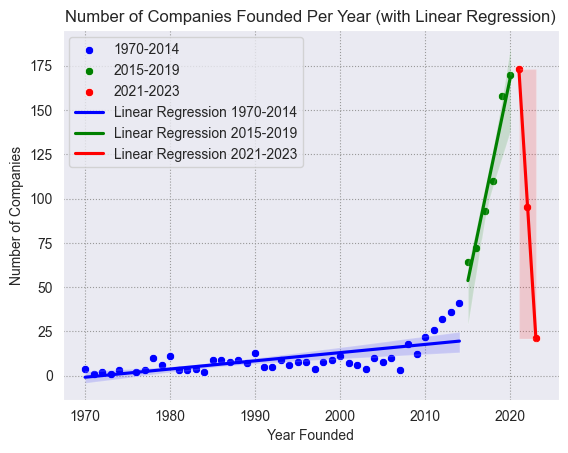

In [23]:
# Scatter plot with seaborn for each period
sns.scatterplot(data=subset_1970_2014, x='year_founded', y='company', color='blue', label='1970-2014')
sns.scatterplot(data=subset_2015_2020, x='year_founded', y='company', color='green', label='2015-2019')
sns.scatterplot(data=subset_2021_2023, x='year_founded', y='company', color='red', label='2021-2023')

# Adding linear regression lines with seaborn
sns.regplot(x='year_founded', y='company', data=subset_1970_2014, scatter=False, color='blue', label='Linear Regression 1970-2014')
sns.regplot(x='year_founded', y='company', data=subset_2015_2020, scatter=False, color='green', label='Linear Regression 2015-2019')
sns.regplot(x='year_founded', y='company', data=subset_2021_2023, scatter=False, color='red', label='Linear Regression 2021-2023')

plt.xlabel('Year Founded')
plt.ylabel('Number of Companies')
plt.title('Number of Companies Founded Per Year (with Linear Regression)')
plt.legend()
plt.show()